# Exploring results from different models

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import pymongo
import json
import datetime
import pickle
import functions as fn
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import io
from sqlalchemy import create_engine
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Retrieve information to connect to the database
keys = fn.get_keys("/Users/jjherranzsarrion/.secret/local_info.json")
username = keys['username']
password = keys['password']

In [4]:
# Select your time ranges and add them in variables
train_window_end = '2018-08-04 23:59:59'
test_window_start = '2018-08-05 00:00:00'
test_window_end = '2018-08-07 23:59:59'
previous_day_start = '2018-08-04 00:00:00'

## Extract calculated features

In [5]:
user_statistics = fn.get_aggregated_user_statistics(username, password, previous_day_start, train_window_end)

/Users/jjherranzsarrion/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/jjherranzsarrion/Documents/Data Science/FlatIron School/capstone/payments/venmo/functions.py:838: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  trans_made.fillna(0, inplace=True)
/Users/jjherranzsarrion/Documents/Data Science/FlatIron School/capstone/payments/venmo/functions.py:867: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  trans_rec.fillna(0, inp

In [6]:
tran_or_not_df = fn.extract_target(username, password, test_window_start, test_window_end)

In [7]:
# Left join because you don't want to add new unrecorded users that made a transaction on the two testing days
complete_table = pd.merge(user_statistics, tran_or_not_df, 'left', on='user_id')
complete_table.fillna(0, inplace=True)

In [8]:
complete_table['n_trans_made_in_measured_period'].value_counts()

0.0    1003258
1.0      48108
Name: n_trans_made_in_measured_period, dtype: int64

Roughly, ~1M customers didn't make a transaction, whereas ~50K did. It is a very imbalanced dataset.

In [9]:
X = complete_table.drop(['user_id', 'n_trans_made_in_measured_period'], axis=1)
y = complete_table['n_trans_made_in_measured_period']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### There is a clear imbalance problem, therefore we will pass in SMOTE as part of our data preprocessing

SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

## The first model we will experiment with is a Logistic Regression

In [ ]:
# build preprocessing and model pipeline
logreg_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("balance", SMOTE()),
    ("model", LogisticRegression(fit_intercept = False, solver='liblinear'))])

In [ ]:
logreg_pipe = logreg_pipe.fit(X_train, y_train)

In [21]:
#logreg_model = LogisticRegression(fit_intercept = False, solver='liblinear')
#logreg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.barh(cols, model_coefficients)

In [ ]:
# save the model to disk
payment_model = 'logreg_model.joblib'
joblib.dump(logreg_pipe, payment_model)

In [ ]:
# load the model from disk
logreg_pipe = joblib.load(payment_model, mmap_mode=None)

In [ ]:
## save the model to disk
#payment_model = 'logreg_model.sav'
#pickle.dump(logreg_model, open(payment_model, 'wb'))

In [ ]:
## load the model from disk
#logreg_model = pickle.load(open(payment_model, 'rb'))

In [22]:
logreg_y_hat_preds = logreg_pipe.predict_proba(X_test)

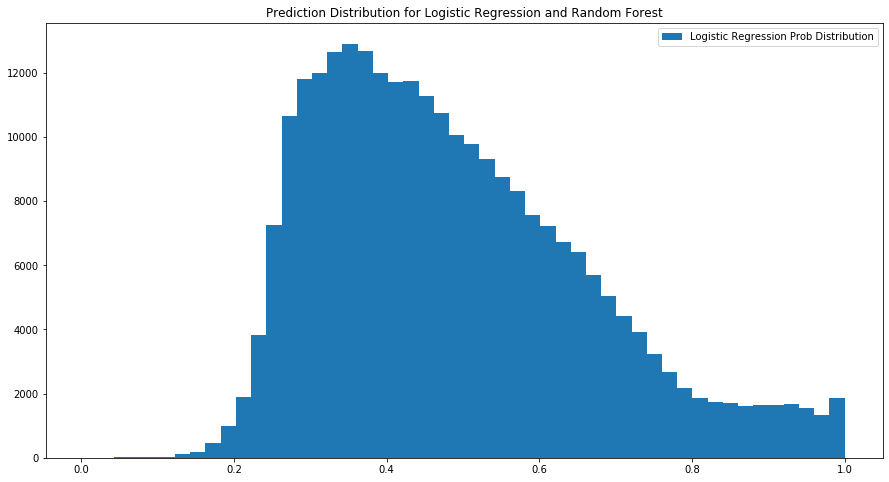

In [24]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(logreg_y_hat_preds[:,1], bins=50)
plt.title('Prediction Distribution for Logistic Regression and Random Forest')
plt.legend(['Logistic Regression Prob Distribution', 'Random Forest Prob Distribution']);

In [39]:
logreg_y_new_preds = np.array(logreg_y_hat_preds)[:,1] > .9

In [40]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Testing Precision: ', precision_score(y_test, logreg_y_new_preds))
print('\n')

print('Testing Recall: ', recall_score(y_test, logreg_y_new_preds))
print('\n')

print('Testing Accuracy: ', accuracy_score(y_test, logreg_y_new_preds))
print('\n')

print('Testing F1-Score: ',f1_score(y_test, logreg_y_new_preds))

Testing Precision:  0.40022255192878337


Testing Recall:  0.2687199070230782


Testing Accuracy:  0.9480296147495454


Testing F1-Score:  0.3215456441839674


### Baseline model without any tunning to deal with class imbalance problem

AUC: 0.6246887466342365


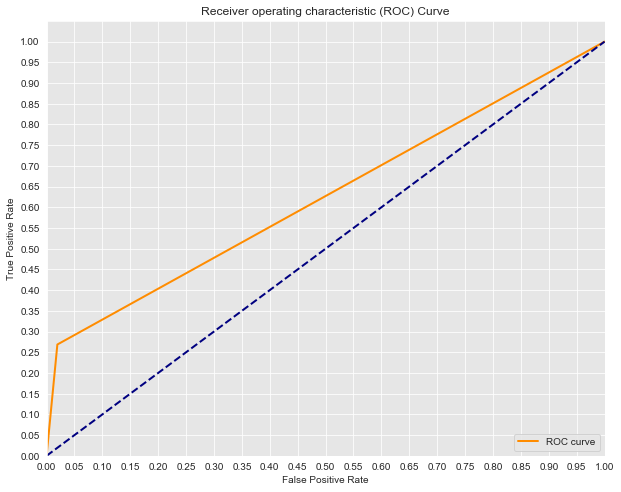

In [41]:
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, logreg_y_new_preds)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
from sklearn.metrics import confusion_matrix

logreg_cnf_matrix = confusion_matrix(y_test, logreg_y_new_preds)
classes = set(y)
print('Logistic Regression Confusion Matrix:\n',logreg_cnf_matrix)

Logistic Regression Confusion Matrix:
 [[245945   4851]
 [  8809   3237]]


### Tunning to deal with class imbalance problem

In [ ]:
#plot_confusion_matrix(cnf_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
# Compare a few different regularization performances:
C_param_range = [0.001,0.01,0.1,1,10,100,1000,]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c,solver='liblinear') #Starter code
    model_log = logreg.fit(X_train_sc, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test_sc)

    y_score = logreg.fit(X_train_sc, y_train).decision_function(X_test_sc)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Tunning seems to have a very meaningless effect on the baseline model

## Random forest

### Resampling the data given its noticeable imbalance problem

In [10]:
print(y.value_counts()) #Previous original class distribution
print(pd.Series(y_train_resampled).value_counts()) #Rebalanced original class distribution

0.0    1003258
1.0      48108
Name: n_trans_made_in_measured_period, dtype: int64


NameError: name 'y_train_resampled' is not defined

In [11]:
# build preprocessing and model pipeline
ent_forest_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("balance", SMOTE()),
    ("model", RandomForestClassifier(n_estimators=10, criterion='gini'))])

In [12]:
ent_forest_pipe = ent_forest_pipe.fit(X_train, y_train)

In [46]:
#ent_forest = RandomForestClassifier(n_estimators=100, criterion='gini')
#ent_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# save the model to disk
forest_model = 'ent_forest.joblib'
joblib.dump(ent_forest_pipe, forest_model)

In [ ]:
# load the model from disk
ent_forest_pipe = joblib.load(forest_model, mmap_mode=None)

In [ ]:
## Save the model in the disk
#forest_model = 'ent_forest.sav'
#pickle.dump(ent_forest, open(forest_model, 'wb'))

In [68]:
## load the model from disk
#ent_forest_model = pickle.load(open('ent_forest.sav', 'rb'))

In [13]:
ent_forest_y_hat_preds = ent_forest_pipe.predict_proba(X_test)

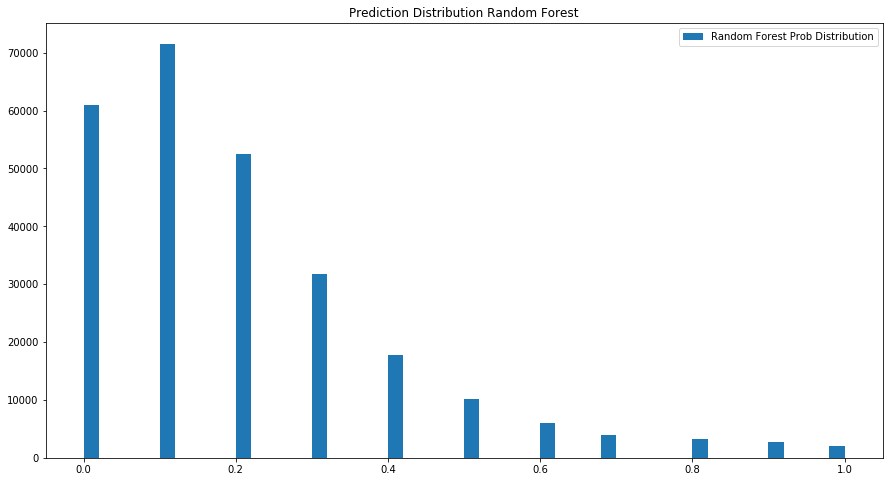

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(ent_forest_y_hat_preds[:,1], bins=50)
plt.title('Prediction Distribution Random Forest')
plt.legend(['Random Forest Prob Distribution']);

__Given that random forests identifies feature interactions automatically, we can see that a particular feature is heavily driving the decision of whether a user is going to make a transaction or not in the future. It is imperative that this is looked into in order to make better models__ 

In [15]:
ent_forest_y_new_preds = np.array(ent_forest_y_hat_preds)[:,1] > 0.9

In [16]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Testing Precision: ', precision_score(y_test, ent_forest_y_new_preds))
print('\n')

print('Testing Recall: ', recall_score(y_test, ent_forest_y_new_preds))
print('\n')

print('Testing Accuracy: ', accuracy_score(y_test, ent_forest_y_new_preds))
print('\n')

print('Testing F1-Score: ',f1_score(y_test, ent_forest_y_new_preds))

Testing Precision:  0.507321681624941


Testing Recall:  0.0891582267972771


Testing Accuracy:  0.9542881274682128


Testing F1-Score:  0.15166278330862104


AUC: 0.5424997341421911


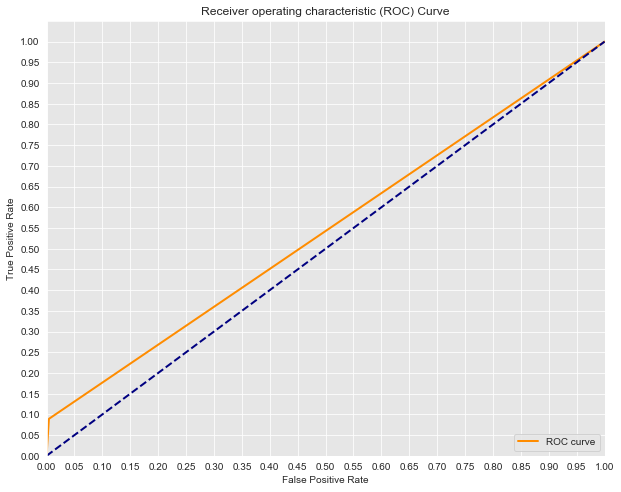

In [17]:
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, ent_forest_y_new_preds)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
ent_forest_cnf_matrix = confusion_matrix(y_test, ent_forest_y_new_preds)
classes = set(y)
print('Random Forest Confusion Matrix:\n', ent_forest_cnf_matrix)

Random Forest Confusion Matrix:
 [[249753   1043]
 [ 10972   1074]]


In [19]:
print(classification_report(y_test, ent_forest_y_new_preds))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    250796
         1.0       0.51      0.09      0.15     12046

    accuracy                           0.95    262842
   macro avg       0.73      0.54      0.56    262842
weighted avg       0.94      0.95      0.94    262842



In [ ]:
ent_forest_model.score(X_train_sc, y_train)

In [ ]:
ent_forest_model.score(X_test_sc, y_test)

In [88]:
def plot_feature_importances(X, X_train, model):
    """Function that plots a barchart of the individual features and 
    their corresponding feature importance."""
    n_features = X_train.shape[1]
    plt.figure(figsize=(12, 10))
    features = list(zip(X.columns, model.feature_importances_))
    sorted_features = sorted(features, key=lambda x: x[1])   
    sorted_imp = [imp[1] for imp in sorted_features if imp[1] > 0.004]
    sorted_fts = [fts[0] for fts in sorted_features if fts[1] > 0.004]
    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    plt.yticks(np.arange(len(sorted_fts)), sorted_fts)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.title("Decision tree features where importance is more than 0.04%")
    return plt.show()

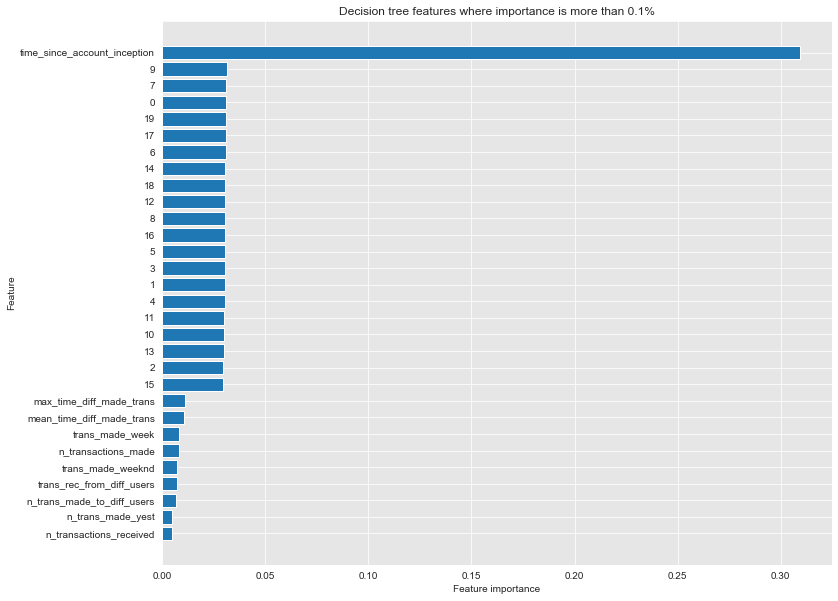

In [89]:
plot_feature_importances(X, X_train_resampled, ent_forest_model)

## Training new model with only the required features

In [11]:
column_to_be_dropped = (['personalised_bio', 'mentions', 'likes', 'comments', 'unsettled',
                         'max_time_diff_received_trans', 'mean_time_diff_received_trans',
                         'n_trans_rec_yest', 'trans_rec_week', 'trans_rec_weeknd', 'user_id',
                         'n_trans_made_in_measured_period', 'n_trans_made_to_diff_users',
                         'n_trans_made_yest'])

In [12]:
X_reduced = complete_table.drop(column_to_be_dropped, axis=1)
y = complete_table['n_trans_made_in_measured_period']

In [13]:
X_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051366 entries, 0 to 1051365
Data columns (total 28 columns):
time_since_account_inception    1051366 non-null float64
0                               1051366 non-null float64
1                               1051366 non-null float64
2                               1051366 non-null float64
3                               1051366 non-null float64
4                               1051366 non-null float64
5                               1051366 non-null float64
6                               1051366 non-null float64
7                               1051366 non-null float64
8                               1051366 non-null float64
9                               1051366 non-null float64
10                              1051366 non-null float64
11                              1051366 non-null float64
12                              1051366 non-null float64
13                              1051366 non-null float64
14                              

In [66]:
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, random_state=42)

## Building the model's pipeline

In [43]:
from imblearn.pipeline import Pipeline
# build preprocessing and model pipeline
red_forest_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("balance", SMOTE()),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini'))])

In [ ]:
red_forest_pipe = red_forest_pipe.fit(X_train_red, y_train)

In [60]:
# save the model to disk
red_forest_model = 'red_forest_pipe.joblib'
joblib.dump(red_forest_pipe, red_forest_model)

['red_forest_pipe.joblib']

In [61]:
# load the model from disk
red_forest_pipe = joblib.load(red_forest_model, mmap_mode=None)

In [168]:
## Save the model in the disk
#payments = 'red_ent_forest.sav'
#pickle.dump(red_ent_forest, open(payments, 'wb'))

In [ ]:
## load the model from disk
#red_ent_forest_model = pickle.load(open(payments, 'rb'))

In [87]:
new_user = {}
new_user['time_since_account_inception'] = 5.48448e+08
new_user['n_transactions_made'] = 2
new_user['n_transactions_made_during_weekend'] = 0
new_user['n_transactions_made_during_week'] = 2
new_user['n_transactions_rec'] = 1
new_user['transactions_rec_from_diff_users'] = 1
new_user['max_time_between_transactions'] = 525343
new_user['mean_time_between_transactions'] = 525343

In [98]:
import regex
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import string

In [99]:
# Dealing with the text aspect
def get_clean_text_pattern(recomposed_note):
    """Function that filters through the notes, retrieves those that match
     the specified pattern and removes stopwords."""
    pattern = "([a-zA-Z0-9\\\]+(?:'[a-z]+)?)"
    recomposed_note_raw = nltk.regexp_tokenize(recomposed_note, pattern)
    # Create a list of stopwords and remove them from our corpus
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    # additional slang and informal versions of the original words had to be added to the corpus.
    stopwords_list += (["im", "ur", "u", "'s", "n", "z", "n't", "brewskies", "mcd’s", "Ty$",
                        "Diploooooo", "thx", "Clothessss", "K2", "B", "Comida", "yo", "jobby",
                        "F", "jus", "bc", "queso", "fil", "Lol", "EZ", "RF", "기프트카드", "감사합니다",
                        "Bts", "youuuu", "X’s", "bday", "WF", "Fooooood", "Yeeeeehaw", "temp",
                        "af", "Chipoodle", "Hhuhhyhy", "Yummmmers", "MGE", "O", "Coook", "wahoooo",
                        "Cuz", "y", "Cutz", "Lax", "LisBnB", "vamanos", "vroom", "Para", "el", "8==",
                        "bitchhh", "¯\\_(ツ)_/¯", "Ily", "CURRYYYYYYY", "Depósito", "Yup", "Shhhhh"])

    recomposed_note_stopped = ([w.lower() for w in recomposed_note_raw if w not in stopwords_list])
    return recomposed_note_stopped

In [100]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [101]:
def lemmatize_notes(recomposed_note_stopped):
    "Function that lemmatizes the different notes."
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmatized_notes = []
    for sentence in recomposed_note_stopped:
        for word in nltk.word_tokenize(sentence):
            lem = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            lemmatized_notes.append(lem)
    return lemmatized_notes

In [102]:
# Dealing with the text aspect
recomposed_note_stopped = get_clean_text_pattern('Thank god we got a ride')
lemmatized_notes = lemmatize_notes(recomposed_note_stopped)
# Load the vectorizer model
vectorizer = Doc2Vec.load("d2v.model")
# Find the vectors for each note in the whole note corpus
_vectrs = np.array(vectorizer.infer_vector(lemmatized_notes))
for i in range(len(_vectrs)):
    new_user[f'text_vector_{i}'] = _vectrs[i]

In [105]:
new_user_df = pd.DataFrame([new_user])

In [106]:
new_user_df

,time_since_account_inception,n_transactions_made,n_transactions_made_during_weekend,n_transactions_made_during_week,n_transactions_rec,transactions_rec_from_diff_users,max_time_between_transactions,mean_time_between_transactions,text_vector_0,text_vector_1,...,text_vector_10,text_vector_11,text_vector_12,text_vector_13,text_vector_14,text_vector_15,text_vector_16,text_vector_17,text_vector_18,text_vector_19
0,548448000.0,2,0,2,1,1,525343,525343,0.567829,-0.125577,...,-0.548474,-1.381222,0.38674,0.012948,-0.385442,-0.399037,0.13569,-0.484854,-0.346855,-1.092214


In [48]:
red_ent_forest_y_hat_preds = red_forest_pipe.predict_proba(X_test)

In [107]:
red_forest_pipe.predict_proba(new_user_df)

array([[0.7, 0.3]])

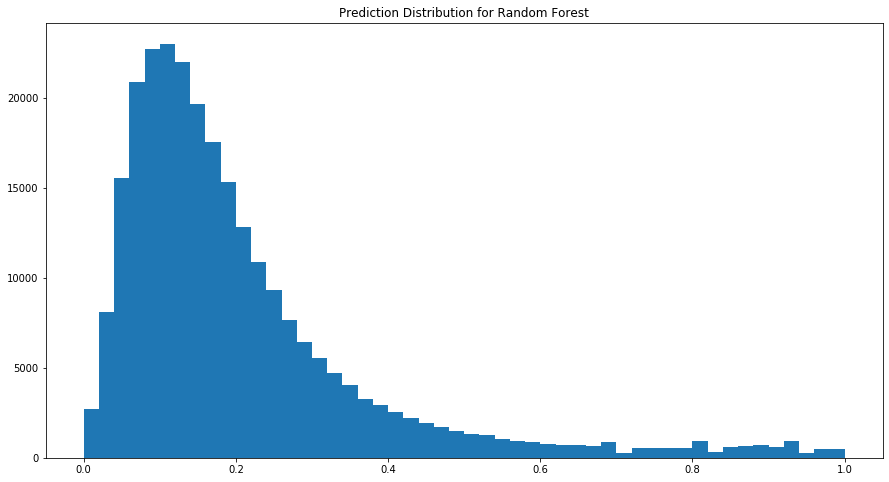

In [49]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(red_ent_forest_y_hat_preds[:,1], bins=50)
plt.title('Prediction Distribution for Random Forest');

In [50]:
red_ent_forest_y_new_preds = np.array(red_ent_forest_y_hat_preds)[:,1] > .9

In [51]:
print('Testing Precision: ', precision_score(y_test, red_ent_forest_y_new_preds))
print('\n')

print('Testing Recall: ', recall_score(y_test, red_ent_forest_y_new_preds))
print('\n')

print('Testing Accuracy: ', accuracy_score(y_test, red_ent_forest_y_new_preds))
print('\n')

print('Testing F1-Score: ',f1_score(y_test, red_ent_forest_y_new_preds))

Testing Precision:  0.5460420032310178


Testing Recall:  0.11223642702971941


Testing Accuracy:  0.9550376271676521


Testing F1-Score:  0.18620024789973832


In [52]:
red_ent_forest_cnf_matrix = confusion_matrix(y_test, red_ent_forest_y_new_preds)
classes = set(y)
print('Random Forest Confusion Matrix:\n', red_ent_forest_cnf_matrix)

Random Forest Confusion Matrix:
 [[249672   1124]
 [ 10694   1352]]


In [53]:
print(classification_report(y_test, red_ent_forest_y_new_preds))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    250796
         1.0       0.55      0.11      0.19     12046

    accuracy                           0.96    262842
   macro avg       0.75      0.55      0.58    262842
weighted avg       0.94      0.96      0.94    262842



In [ ]:
_response = [('time_since_account_inception', '20 March 2014'), ('n_transactions_made_last_week', '2'),
             ('n_transactions_made_yesterday', '0'), ('n_transactions_made_during_weekend', '1'),
             ('n_transactions_made_to_diff_users', '1'), ('max_time_between_transactions', '5'),
             ('unsuccesful_transactions', '0'), ('description', 'food')]

In [ ]:
for response in _response:
    print(response)

In [ ]:
complete_table = pd.merge(user_statistics, tran_or_not_df, 'left', on='user_id')
complete_table.fillna(0, inplace=True)

In [ ]:
complete_table

In [ ]:
people_with_trans = complete_table.loc[complete_table['n_trans_made_in_measured_period'] != 0]

In [ ]:
people_with_trans['time_since_account_inception'].value_counts()